In [1]:
import shap
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from seaborn import kdeplot
from pickle import dump, load
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon
import warnings; warnings.simplefilter('ignore')

In [2]:
loc = EarthLocation.of_site('greenwich') 

def to_numpy(c):
    return np.array([c.x/u.km, c.y/u.km, c.z/u.km])

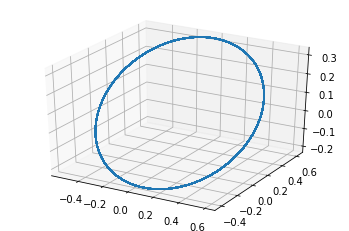

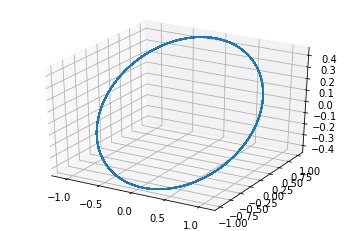

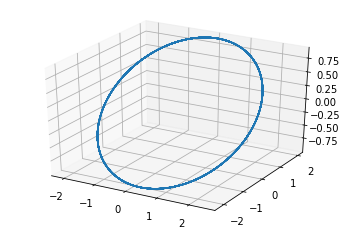

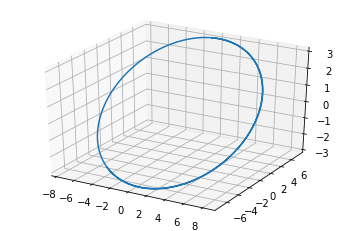

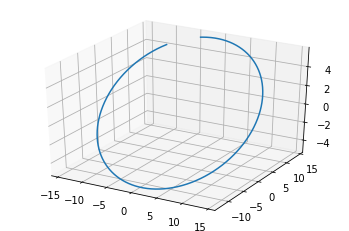

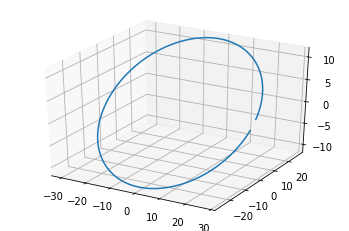

In [15]:
#Use the JPL Library to generate data

planets = ['mercury', 'venus', 'mars', 'jupiter', 'saturn', 'uranus']
days = {
    'mercury':7000,
    'venus':7000,
    'mars':7000,
    'jupiter':7000,
    'saturn':10000,
    'uranus':30000
}
samples = 15000

START_TIME = 2287185
SCALE = 10**(-8)


X = dict()
y = dict()


for planet in planets:
    t = Time(START_TIME + np.linspace(0,days[planet],samples), format='jd')
    with solar_system_ephemeris.set('jpl'):
        plnt = get_body(planet, t, loc)
        sun = get_body('sun', t, loc)
    r = sun.cartesian-plnt.cartesian
    rcoords = np.array([to_numpy(r[i]) for i in range(len(r))])*SCALE
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(rcoords[:,0], rcoords[:,1], rcoords[:,2])

    X[planet] = pd.DataFrame({
        "RA": plnt.ra[:-2],
        "Dec": plnt.dec[:-2],
        "Dist_Sun": np.linalg.norm(rcoords, axis=1)[:-2]
    })
    y[planet] = pd.DataFrame({"Second Difference":np.linalg.norm(rcoords[2:] - 2*rcoords[1:-1] + rcoords[:-2], axis=1)})


In [16]:
#Run randomized hyperparameter search for each of the training targets
plt.clf()

LOAD = False

if LOAD:
    params = load(open("params.bin" , "rb"))
    
else:
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    params = dict()
    for planet in planets:
        rf = RandomForestRegressor()
        rf_random = RandomizedSearchCV(estimator = rf, 
                                       param_distributions = random_grid, 
                                       n_iter = 100, cv = 3, 
                                       verbose=2, 
                                       random_state=1, 
                                       n_jobs = -1)
        rf_random.fit(X[planet],y[planet])
        params[planet] = rf_random.best_params_
        print("Best parameters for "+planet+":")
        pprint(params[planet])
        print()

dump(params, open("params.bin", "wb")) #pickle best parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished


Best parameters for mercury:
{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 400}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.5min finished


Best parameters for venus:
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1000}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished


Best parameters for mars:
{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 400}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished


Best parameters for jupiter:
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 600}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


Best parameters for saturn:
{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 200}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished


Best parameters for uranus:
{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200}



<Figure size 432x288 with 0 Axes>

Error for mercury:
Bias: 5.507659989213246e-07
Variance: 3.849926883206574e-08
SSE 3.849957217525131e-08

Error for venus:
Bias: -5.76635664915697e-10
Variance: 5.981214756468504e-12
SSE 5.981215088977194e-12

Error for mars:
Bias: -1.4257081118961086e-07
Variance: 3.739842973405347e-11
SSE 3.7418756170256735e-11

Error for jupiter:
Bias: -1.1754895848972493e-07
Variance: 5.902575459533544e-11
SSE 5.903957235297745e-11

Error for saturn:
Bias: -3.0986289787749524e-07
Variance: 1.4355148865898516e-10
SSE 1.436475036744662e-10

Error for uranus:
Bias: 3.908639714652161e-07
Variance: 6.910490127856838e-10
SSE 6.912017874298734e-10



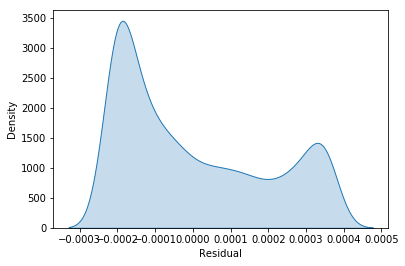

In [17]:
#Evaluate model performance on a validation dataset

residuals = dict()
rfs = dict()

ax = None

for planet in planets:
    pparams = params[planet]
    rf = RandomForestRegressor(n_estimators=pparams["n_estimators"], 
                                            min_samples_split = pparams["min_samples_split"], 
                                            min_samples_leaf = pparams["min_samples_leaf"], 
                                            max_features = pparams["max_features"], 
                                            max_depth = pparams["max_depth"], 
                                            bootstrap = pparams["bootstrap"])
    X_train, X_test, y_train, y_test = train_test_split(X[planet], y[planet]) 
    rf.fit(X_train, y_train)
    
    res = y_test.to_numpy().ravel() - rf.predict(X_test)
    
    print("Error for "+planet+":")
    bias = np.mean(res)
    variance = np.var(res)
    error = bias**2 + variance
    print("Bias: "+str(bias))
    print("Variance: "+str(variance))
    print("SSE "+str(error))
    print()
    residuals[planet] = res
    ax = kdeplot(
        data=pd.Series(residuals[planet]), shade=True)
    ax.set(xlabel='Residual', ylabel='Density')
    
    rf.fit(X[planet], y[planet])
    rfs[planet] = rf

ax.get_figure().savefig("kde.png")
    
dump(residuals, open("residuals.bin", "wb")) #pickle residuals
dump(rfs, open("residuals.bin", "wb")) #pickle random forests

In [18]:
#Compute SHAP values for each planet

shap_values = dict()
SHAP_N = 1000 #use -1 to select the whole input dataset
Xshap = {planet:X[planet].sample(n=SHAP_N) for planet in planets} if SHAP_N > 0 else X

LOAD = False

if LOAD:
    shap_values = load(open("shap_values.bin", "rb"))
    Xshap = load(open("Xshap.bin", "rb"))

for planet in planets:
    if not LOAD:
        explainer = shap.TreeExplainer(rfs[planet])
        shap_values[planet] = explainer.shap_values(Xshap[planet])
    shap.summary_plot(shap_values[planet], Xshap[planet], show=False)
    plt.savefig("Summary_Plot_"+planet+".png",bbox_inches='tight')
    plt.clf()

dump(shap_values, open("shap_values.bin", "wb"))
dump(Xshap, open("Xshap.bin", "wb"))

<Figure size 576x194.4 with 0 Axes>

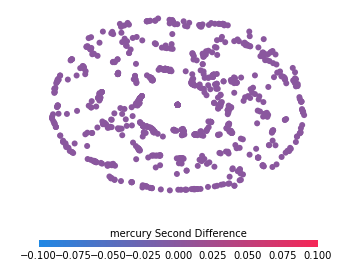

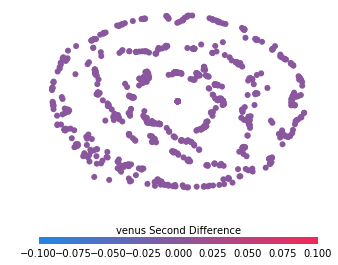

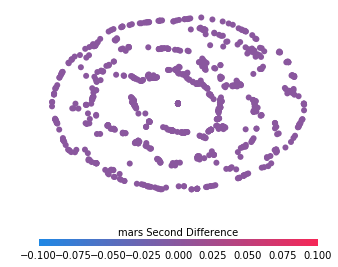

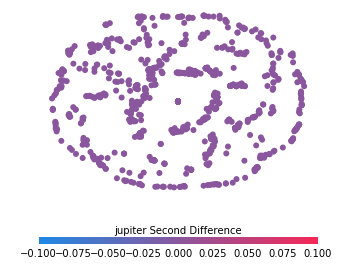

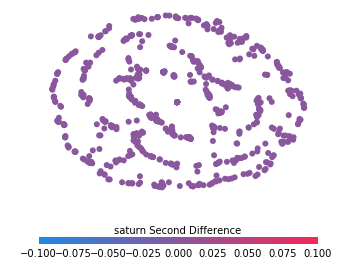

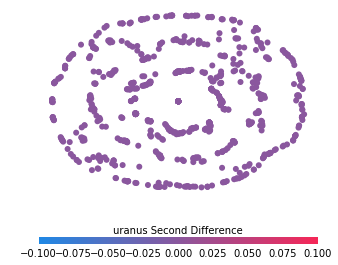

In [19]:
#TSNE Visualization of the SHAP values

cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

for planet in planets:
    shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[planet])
    f = plt.figure(figsize=(5,5))
    plt.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=shap_values[planet][:1000,:].sum(1).astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = plt.colorbar(label=planet+" Second Difference", aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    plt.gca().axis("off")
    plt.savefig("TSNE_"+planet+".png",bbox_inches='tight')

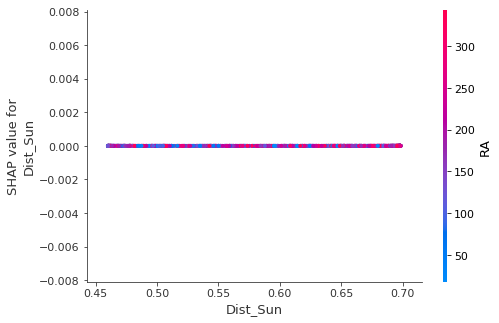

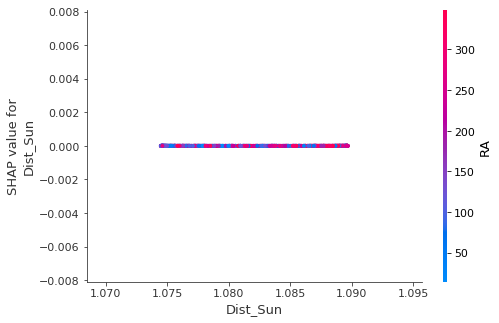

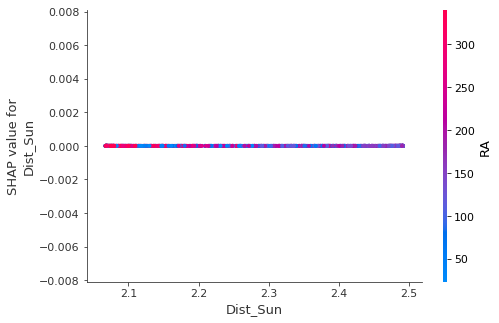

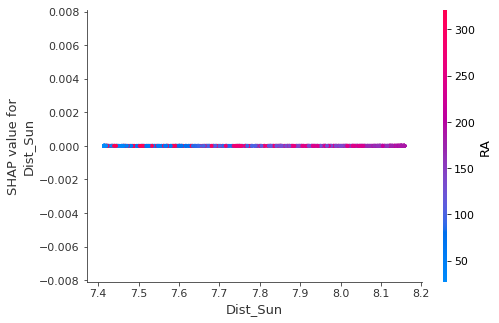

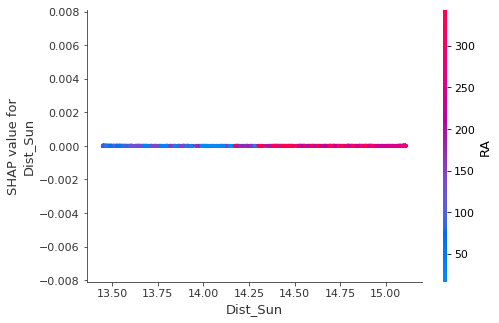

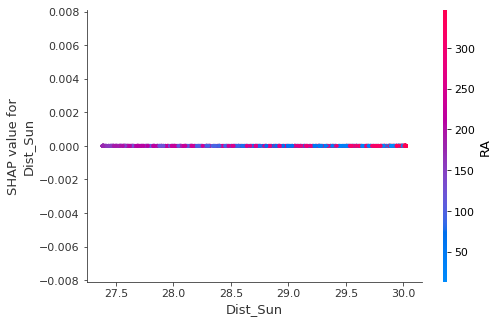

In [20]:
# Dependence Plots

#SHAP dependence on Dist_Sun
X_dist_sun = dict()
y_sv = dict()

LOAD = False

if LOAD:
    X_dist_sun = load(open("Xdep.bin", "rb"))
    y_sv = load(open("ydep.bin", "rb"))

for planet in planets:
    if not LOAD:
        idx = np.where(Xshap[planet].columns=="Dist_Sun")[0][0]
        X_dist_sun[planet] = Xshap[planet].iloc[:,idx]
        y_sv[planet] = shap_values[planet][:,idx]
    fig = shap.dependence_plot("Dist_Sun", shap_values[planet], Xshap[planet], show=False)
    plt.savefig("Dependence_Plot_"+planet+".png",bbox_inches='tight')

dump(X_dist_sun, open("Xdep.bin", "wb"))
dump(y_sv, open("ydep.bin", "wb"))
    